#### setup colab

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd '/content/drive/My Drive/people'

Mounted at /content/drive/
/content/drive/My Drive/people


#### imports

In [1]:
import pandas as pd
from scipy import stats
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

from sklearn.utils import resample
from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from tqdm import tqdm
import time
import matplotlib.pyplot as plt

#### load raw

In [2]:
test=pd.read_csv("test.csv");train=pd.read_csv("train.csv");train_raw=train.copy();test_raw=test.copy()

# preprocessing

#### data points modification
job_level, person_level,age, Education_level, year_graduated, achievement_target_1(2&3)
- (may need info on which year is this data taken from)
- info from each columns

penyesuaian nilai angka **age** (current_age), **year_graduated** (years_graduated)

mengubah Dtype year_graduated sekaligus nilai yg tidak sesuai menjadi NaN

In [3]:
train['year_graduated']=pd.to_numeric(train['year_graduated'], errors='coerce', downcast ='integer')
# train['year_graduated'].astype('int32') #cannot convert NA or inf to integer
# keduanya dengan asumsi ini tahun 2019
tahun_skrg=2019

train['current_age']=tahun_skrg-train['age']
train['years_graduated']=tahun_skrg-train['year_graduated']
train.drop(['age','year_graduated','Education_level'],axis=1,inplace=True)

 penghapusan sebagian karakter untuk dijadikan bentuk ordinal: **job_level**, **person_level**, dan , **education_level**

In [4]:
train['job_level']=train['job_level'].str.lstrip('JG0')
train['person_level']=train['person_level'].str.lstrip('PG0')
train['education_level']=train['person_level'].str.lstrip('level_')

train['job_level']=pd.to_numeric(train['job_level'], errors='raise')
train['person_level']=pd.to_numeric(train['person_level'], errors='raise')
train['education_level']=pd.to_numeric(train['education_level'], errors='raise')

**achievement_target_1** & **achievement_target_2** diolah lebih lanjut

In [5]:
targets=['achievement_target_1','achievement_target_2']
for target in targets:
    train.loc[(train[target] == 'achiev_< 50%' )|( train[target] == 'Pencapaian < 50%'), target] = 1
    train.loc[(train[target] == 'achiev_50%-100%' )|( train[target] == 'Pencapaian 50%-100%'), target] = 2
    train.loc[(train[target] == 'achiev_100%-150%' )|( train[target] == 'Pencapaian 100%-150%'), target] = 3
    train.loc[(train[target] == 'achiev_> 1.5' )|( train[target] == 'Pencapaian > 1.5'), target] = 4
#     train.loc[train[target] == 'Tidak diberikan target', target] = float('NaN')

    train[target]=pd.to_numeric(train[target], errors='coerce') #NaN given here
    
train['achievement_target_3'] = train['achievement_target_3'].apply(lambda x: 1 if x == 'reached' else 0)
#dibikin binernya ditentukan karena 'penting' (kayanya) untuk penentuan 0 dan 1-nya sesuai

buat **<font color='green'>test</font>**


In [6]:
test['year_graduated']=pd.to_numeric(test['year_graduated'], errors='coerce', downcast ='integer')

test['current_age']=tahun_skrg-test['age'] #asumsi tahun 2019 sekarang
test['years_graduated']=tahun_skrg-test['year_graduated']
test.drop(['age','year_graduated','Education_level'],axis=1,inplace=True)

test['job_level']=test['job_level'].str.lstrip('JG0')
test['person_level']=test['person_level'].str.lstrip('PG0')
test['education_level']=test['person_level'].str.lstrip('level_')

test['job_level']=pd.to_numeric(test['job_level'], errors='raise')
test['person_level']=pd.to_numeric(test['person_level'], errors='raise')
test['education_level']=pd.to_numeric(test['education_level'], errors='raise')

targets=['achievement_target_1','achievement_target_2']
for target in targets:
    test.loc[(test[target] == 'achiev_< 50%' )|( test[target] == 'Pencapaian < 50%'), target] = 1
    test.loc[(test[target] == 'achiev_50%-100%' )|( test[target] == 'Pencapaian 50%-100%'), target] = 2
    test.loc[(test[target] == 'achiev_100%-150%' )|( test[target] == 'Pencapaian 100%-150%'), target] = 3
    test.loc[(test[target] == 'achiev_> 1.5' )|( test[target] == 'Pencapaian > 1.5'), target] = 4
#     test.loc[test[target] == 'Tidak diberikan target', target] = float('NaN')

    test[target]=pd.to_numeric(test[target], errors='coerce') #NaN given here
    
test['achievement_target_3'] = test['achievement_target_3'].apply(lambda x: 1 if x == 'reached' else 0)
#dibikin binernya ditentukan karena 'penting' (kayanya) untuk penentuan 0 dan 1-nya sesuai

#### outliers management
fiturnya banyak, jadi sayang bgt kalo gara2 1 fitur ada outlier lgsg dibuang
outlier ada di: yg dtypenya int dan float


In [7]:
angka_columns = train.loc[:, (train.dtypes == np.float64)|(train.dtypes == np.int64)].columns
                        
#ubah semua outliers jadi NaN (untuk nanti diubah jadi mean??)                        
for col in angka_columns:
    z =     np.abs((train[col] - train[col].mean())/train[col].std(ddof=0))
    #print(z,col)
    train.loc[z > 3, col] = float('NaN')

buat **<font color='green'>test</font>**


In [8]:
angka_columns = test.loc[:, (test.dtypes == np.float64)|(test.dtypes == np.int64)].columns
                        
#ubah semua outliers jadi NaN (untuk nanti diubah jadi mean??)                        
for col in angka_columns:
    z =     np.abs((test[col] - test[col].mean())/test[col].std(ddof=0))
    #print(z,col)
    test.loc[z > 3, col] = float('NaN')

In [9]:
# print('cek perubahan setelah main outlier',train_raw.info(),train.info())

save dataset sampe checkpoint ngilangin outlier

In [10]:
train.to_csv('train_setelah_buang_outlier.csv')

#### Dtype modification **binary and 1 hot**
sisa 4 kategorikal yang masi dalam bentuk objek, ubah.

employee type 1hot, employee status binary, gender binary, marital_status_married(Y/N) binary, achievement target 3 binary

In [11]:
def biner(df,col):
    for c in col:
        df[c] = LabelEncoder().fit_transform(df[c])
        
biner(train,['Employee_status','gender','marital_status_maried(Y/N)'])

buat **<font color='green'>test</font>**


In [12]:
biner(test,['Employee_status','gender','marital_status_maried(Y/N)'])

In [13]:
#1hotting every column with object dtype left
def onehot(df_list,col): #list form
    df_list_1h=[]
    for df in df_list:
#         df_obj=df.select_dtypes('object')
        for c in range(len(col)):
#             label_df = pd.DataFrame(df[col[c]], columns=[col[c]])
            dum_df = pd.get_dummies(df[col[c]], columns=[col[c]], prefix=col[c])
            df=df.join(dum_df)
            df=df.drop(col[c], axis=1)
        df_list_1h.append(df)
        
    return df_list_1h
        
col=train.select_dtypes('object').columns

train,=onehot([train],col)

buat **<font color='green'>test</font>**


In [14]:
test,=onehot([test],col)

In [15]:
# train.info()

#### NaNs management


In [16]:
# train.mean()

In [17]:
train.fillna(train.mean(),inplace=True)

buat **<font color='green'>test</font>**


In [18]:
test.fillna(test.mean(),inplace=True)

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22005 entries, 0 to 22004
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   job_level                              22005 non-null  float64
 1   job_duration_in_current_job_level      22005 non-null  float64
 2   person_level                           22005 non-null  float64
 3   job_duration_in_current_person_level   22005 non-null  float64
 4   job_duration_in_current_branch         22005 non-null  float64
 5   Employee_status                        22005 non-null  int32  
 6   gender                                 22005 non-null  int32  
 7   marital_status_maried(Y/N)             22005 non-null  int32  
 8   number_of_dependences                  22005 non-null  float64
 9   number_of_dependences (male)           22005 non-null  float64
 10  number_of_dependences (female)         22005 non-null  float64
 11  GP

#### balancing training data

#### pemecahan jadi validasi dan feature/target

In [20]:
X_train = train.drop('Best Performance', axis=1)
y_train = train['Best Performance']

X_train, X_val, y_train, y_val = split(
                X_train, y_train, test_size=0.2, random_state=133)

#### scaling

In [21]:
scaler = preprocessing.StandardScaler().fit(X_train)

#### saving processed dataset

In [22]:
train.to_csv('train_preprocessed_201229.csv')
test.to_csv('test_preprocessed_201229.csv')

# exploratory

#### IV

In [23]:
X_cols = [i for i in train.columns if i != 'Best Performance']
train_set_woe = train.copy()
bin_names = []
woe = []
iv = []

for i in tqdm(X_cols): 
    var_name = str(i)
    var_bins = var_name + '_bin'
    bin_names.append(var_bins)

    train_set_woe[var_bins] = pd.qcut(train[i], q=4, duplicates='drop')

    index = train_set_woe.groupby(var_bins).count().index
    count = train_set_woe.groupby(var_bins).count()['Best Performance'].values
    good = train_set_woe.groupby(var_bins).sum()['Best Performance'].values
    bad = count - good

    woe_temp = pd.DataFrame()
    woe_temp['group'] = index
    woe_temp['count'] = count
    woe_temp['good'] = good
    woe_temp['bad'] = bad
    woe_temp['total_distri'] = woe_temp['count']/sum(woe_temp['count'])
    woe_temp['good_distri'] = woe_temp['good']/sum(woe_temp['good'])
    woe_temp['bad_distri'] = woe_temp['bad']/sum(woe_temp['bad'])
    woe_temp['WOE'] = np.log(woe_temp['good_distri'] / woe_temp['bad_distri'])
    woe_temp['WOE%'] = woe_temp['WOE'] * 100
    
    for j in range(len(woe_temp['group'])):
        woe.append({'feature': var_bins, 'bin': woe_temp['group'][j], 'woe_val': woe_temp['WOE%'][j]})
    
    iv_val = sum((woe_temp['good_distri'] - woe_temp['bad_distri']) * woe_temp['WOE'])
    iv.append({'feature': var_name, 'IV': iv_val})
        
iv = pd.DataFrame(iv)
woe = pd.DataFrame(woe)

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [01:03<00:00,  2.06s/it]


In [24]:
# iv.to_csv('iv.csv')
# woe.to_csv('woe.csv')


iv=pd.read_csv('iv.csv')
woe=pd.read_csv('woe.csv')

In [25]:
iv = iv.sort_values('IV', ascending=False).reset_index(drop=True)
iv

,Unnamed: 0,feature,IV
0,3,job_duration_in_current_person_level,0.267324
1,13,job_duration_from_training,0.194185
2,1,job_duration_in_current_job_level,0.178257
3,22,achievement_target_1,0.176493
4,19,Avg_achievement_%,0.116796
5,20,Last_achievement_%,0.110995
6,4,job_duration_in_current_branch,0.109841
7,15,job_rotation,0.086368
8,14,branch_rotation,0.075467
9,25,current_age,0.069289


In [26]:

features=[] 
for i in range(len(iv)):
    if iv.IV[i]<0.02:
        lower_limit_iv_i=i
        break
    features.append(iv.feature[i])

print("Only the top "+str(i)+" features are used for training and prediction as it is the only significant ones (more than 0.02 IV)")

print('\nto be used as features for training: \n'+str(features ),len(features))



Only the top 14 features are used for training and prediction as it is the only significant ones (more than 0.02 IV)

to be used as features for training: 
['job_duration_in_current_person_level', 'job_duration_from_training', 'job_duration_in_current_job_level', 'achievement_target_1', 'Avg_achievement_%', 'Last_achievement_%', 'job_duration_in_current_branch', 'job_rotation', 'branch_rotation', 'current_age', 'years_graduated', 'job_duration_as_permanent_worker', 'GPA', 'number_of_dependences'] 14


In [27]:
features

['job_duration_in_current_person_level',
 'job_duration_from_training',
 'job_duration_in_current_job_level',
 'achievement_target_1',
 'Avg_achievement_%',
 'Last_achievement_%',
 'job_duration_in_current_branch',
 'job_rotation',
 'branch_rotation',
 'current_age',
 'years_graduated',
 'job_duration_as_permanent_worker',
 'GPA',
 'number_of_dependences']

selecting only features with high IV

In [28]:
test=test[features]
features.append('Best Performance')
train=train[features]

visualisasi aja ini mah

In [29]:
# ivs=iv.iloc[:lower_limit_iv_i,:]

In [30]:
iv = ivs.sort_values('IV', ascending=False).reset_index(drop=True)
color = []
for i in range(len(iv)):
    if iv['IV'][i] < 0.0199:
        color.append('#850000')
    elif iv['IV'][i] < 0.1:
        color.append('#CCBB3B')
    elif iv['IV'][i] < 0.3:
        color.append('#AF9500')
    else:
        color.append('#005841')
        
iv['color'] = color

fig, ax = plt.subplots(figsize=(9,15))
y_pos = np.arange(len(iv.feature))

ax.barh(y_pos, iv.IV,color=color)
ax.set_yticks(y_pos)
ax.set_yticklabels(iv.feature)
ax.invert_yaxis() 
ax.set_xlabel('Information Value')
ax.set_title('Features Name with its Corresponding Information Value')

for i, v in enumerate(iv.IV):
    ax.text(v + 0.001, i + .2, str(round(v,3)), color='black', size=9)
    
plt.show()

NameError: name 'ivs' is not defined

In [30]:
print(y_train.value_counts())

0.0    15498
1.0     2106
Name: Best Performance, dtype: int64


the target distribution is extremely **imbalanced**

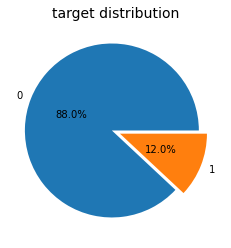

In [33]:
d=y_train.value_counts()[0],y_train.value_counts()[1]

pie, ax = plt.subplots(figsize=[10,4])
labels = ['0','1']
plt.pie(x=d, autopct="%.1f%%", explode=[0.05]*2,labels=labels, pctdistance=0.5)
plt.title("target distribution", fontsize=14);
pie.savefig("DeliveryPieChart.png")

# modelling

_pake yang bni_

#### pipeline model lalu perbandingan

In [32]:
models = Pipeline([
    ('clf', None), 
])

search = GridSearchCV(
    models, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=21), 
    return_train_score=False, #in ver 0.21 hwever, default value was changed from True to False
    scoring=['accuracy', 'recall', 'f1','roc_auc',],
    refit = 'roc_auc', #because the model is extremely imbalanced
    n_jobs = -1,
    param_grid={
        'clf': [GaussianNB(),RandomForestClassifier(),LogisticRegression(max_iter=10000)]}
    ,verbose=1
)

start = time.time()
search.fit(X_train, y_train)
print('total fitting time:', round((time.time() - start)/60,2), 'minute(s)')
best_model=search.best_estimator_

print('Best model:', search.best_params_)
model_comparison = pd.DataFrame(search.cv_results_)
# score= best_score_ #nanti kalo kelamaan ini komen coba
model_comparison

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   15.3s finished


total fitting time: 0.31 minute(s)
Best model: {'clf': RandomForestClassifier()}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,...,std_test_f1,rank_test_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,0.061636,0.002631,0.059442,0.007740,GaussianNB(),{'clf': GaussianNB()},0.262709,0.271230,0.262425,0.265550,...,0.001187,1,0.612536,0.575647,0.619953,0.590857,0.602719,0.600343,0.015740,3
1,6.368973,0.104197,0.496073,0.009824,RandomForestClassifier(),{'clf': RandomForestClassifier()},0.879012,0.879864,0.879864,0.879580,...,0.003500,2,0.638082,0.616647,0.629531,0.635411,0.640581,0.632050,0.008533,1
2,7.516353,1.880636,0.019539,0.007105,LogisticRegression(max_iter=10000),{'clf': LogisticRegression(max_iter=10000)},0.880432,0.880432,0.880432,0.880148,...,0.000000,3,0.633826,0.599197,0.630349,0.612768,0.627767,0.620781,0.012966,2


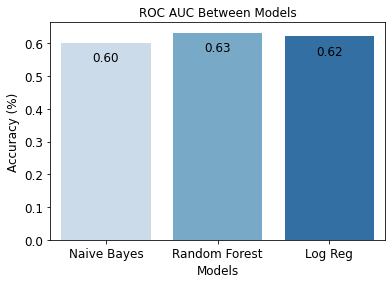

In [33]:
import seaborn as sns

model_comparison['model'] = ['Naive Bayes', 'Random Forest','Log Reg']
ax = sns.barplot('model', 'mean_test_roc_auc', data=model_comparison, capsize=.05, palette='Blues', ci=None)
ax.set_xlabel("Models",fontsize=12)
ax.set_ylabel("Accuracy (%)",fontsize=12)
ax.tick_params(labelsize=12)
ax.axes.set_title("ROC AUC Between Models", fontsize=12)

for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
    ha='center', va='center', fontsize=12, color='black', xytext=(0, -15),
    textcoords='offset points')

Accuracy:  0.8718473074301295
[[3836    3]
 [ 561    1]]


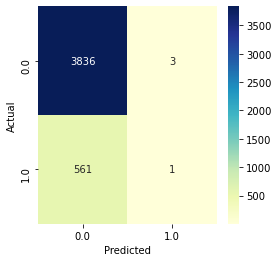

In [34]:
def confusion_matrix_heatmap(cm, index, dim):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    dims = (dim, dim)
    fig, ax = plt.subplots(figsize=dims)
#     sns.heatmap(cmdf, annot=True, cmap="Blues", center=0)
    sns.heatmap(cmdf, annot=True, cmap="YlGnBu", fmt="g")

    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')

prediction_val = best_model.predict(X_val)
print("Accuracy: ", accuracy_score(y_val, prediction_val))
print(confusion_matrix(y_val, prediction_val))
# confusion_matrix_heatmap(confusion_matrix(y_val, prediction_val), loaded_model.classes_, 4)
confusion_matrix_heatmap(confusion_matrix(y_val, prediction_val), best_model.classes_, 4)

No Skill Model: ROC AUC = 0.500
Trained Model: ROC AUC = 0.500


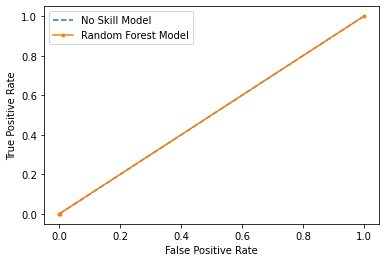

In [35]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

# no skill model
ns_probs = [1 for _ in range(len(y_val))] #random guessing
# ns_probs = [1 for _ in range(28744)] #random guessing
# ns_probs = ns_probs.append([0 for _ in range(20000)]) #random guessing

# calculate scores
ns_auc = roc_auc_score(y_val, ns_probs)
lr_auc = roc_auc_score(y_val, prediction_val)

# summarize scores
print('No Skill Model: ROC AUC = %.3f' % (ns_auc))
print('Trained Model: ROC AUC = %.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_val, prediction_val)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill Model')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest Model')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend and plot
plt.legend()
plt.show()

#### threshold predict diturunin jadi 0.25

Accuracy:  0.792774369461486
[[3385  454]
 [ 458  104]]


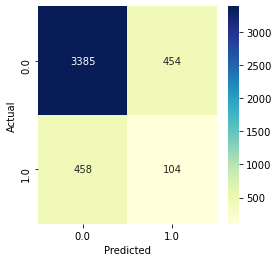

In [36]:
def confusion_matrix_heatmap(cm, index, dim):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    dims = (dim, dim)
    fig, ax = plt.subplots(figsize=dims)
#     sns.heatmap(cmdf, annot=True, cmap="Blues", center=0)
    sns.heatmap(cmdf, annot=True, cmap="YlGnBu", fmt="g")

    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')

prediction_val = (best_model.predict_proba(X_val)[:,1] >= 0.24).astype(int) # set threshold as 0.23
print("Accuracy: ", accuracy_score(y_val, prediction_val))
print(confusion_matrix(y_val, prediction_val))
# confusion_matrix_heatmap(confusion_matrix(y_val, prediction_val), loaded_model.classes_, 4)
confusion_matrix_heatmap(confusion_matrix(y_val, prediction_val), best_model.classes_, 4)

No Skill Model: ROC AUC = 0.500
Trained Model: ROC AUC = 0.533


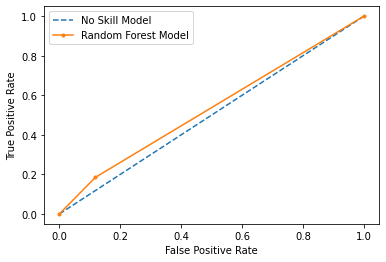

In [37]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

# no skill model
ns_probs = [1 for _ in range(len(y_val))] #random guessing
# ns_probs = [1 for _ in range(28744)] #random guessing
# ns_probs = ns_probs.append([0 for _ in range(20000)]) #random guessing

# calculate scores
ns_auc = roc_auc_score(y_val, ns_probs)
lr_auc = roc_auc_score(y_val, prediction_val)

# summarize scores
print('No Skill Model: ROC AUC = %.3f' % (ns_auc))
print('Trained Model: ROC AUC = %.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_val, prediction_val)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill Model')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest Model')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend and plot
plt.legend()
plt.show()

In [38]:
prediksi_dr_proba= (best_model.predict_proba(X_val)[:,1] >= 0.24).astype(bool) # set threshold as 0.23

In [39]:
prediksi_dr_proba.sum()

558

In [40]:
a

NameError: name 'a' is not defined

In [206]:
prediction_val

array([False,  True, False, ..., False, False,  True])

# prediksi 

In [233]:
prediksi = best_model.predict(test)
prediksi_proba = best_model.predict_proba(test)

In [364]:
prediksi_024 = (best_model.predict_proba(test)[:,1] >= 0.08).astype(int) # set threshold as 0.23, with int

In [365]:
prediksi_024[10:120]

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

hasil di **prediksi_024**

In [258]:
type(df)

pandas.core.frame.DataFrame

output ke DataFrame sesuai contoh *submission*

In [366]:
df=pd.DataFrame()
df['index']=range(0,len(prediksi_024))
df['Best Performance']=prediksi_024

In [367]:
df.to_csv('2.csv', index=False)

 cuba2

In [373]:
a=[2,3,4,5]
q=[1]

In [374]:
b,c,d,e=a

In [375]:
z,=q
zl=q

In [376]:
z,zl

(1, [1])